In [25]:
import os
import pandas as pd
import json
import re
import matplotlib.pyplot as plt

In [26]:
# Function to extract information from config.json
def extract_info_from_config(config_path):
    with open(config_path, 'r') as config_file:
        config_data = json.load(config_file)
        dataset = config_data.get('dataset', '')
        feature = config_data.get('feature', '')
        mode = config_data.get('mode', '')
        param = config_data.get('n_pins', '')
        deeper = config_data.get('deeper', '')
        try:
            manual = config_data.get('manual_lr', '')
            manual = 'Yes' if manual else 'No'
        except: 
            manual = 'No'
    return dataset, feature, mode, param, deeper, manual

# Function to parse the test_PinMNIST files
def parse_test(file_path):
    with open(file_path, 'r') as file:
        content = file.read().strip()
        parts = content.split('|')
        mse = float(parts[0].split(',')[0].split()[1])
        r2mse = float(parts[0].split(',')[1].split()[1])
        npp_part = parts[1].split(';')[0]
        gp_part = parts[1].split(';')[1]
        npp = float(npp_part.split(',')[0].split()[1])
        r2npp = float(npp_part.split(',')[1].split()[1])
        gp = float(gp_part.split(',')[0].split()[1])
        r2gp = float(gp_part.split(',')[1].split()[1])
    return mse, r2mse, npp, r2npp, gp, r2gp

def parse_res(file_path):
    with open(file_path, 'r') as file:
        content = file.read()  # Read the entire file content as a single string
    
    # Define the regular expression pattern to capture MSE, sigma, and the two float values
    pattern = r"MSE: ([\d.]+), R2: ([\d.-]+) \| NPP \(sigma ([\d.]+)\): ([\d.]+), R2: ([\d.-]+); GP: ([\d.]+), R2: ([\d.-]+)"
    
    # Find all matches in the content
    match = re.findall(pattern, content)[0]
    mse = float(match[0])  # Convert MSE value to float
    r2mse = float(match[1])
    sigma = float(match[2])  # Convert sigma value to float
    npp = float(match[3])  # Convert NPP value to float
    r2npp = float(match[4])
    gp = float(match[5])  # Convert GP value to float
    r2gp = float(match[6])
    
    return mse, r2mse, sigma, npp, r2npp, gp, r2gp

def append(df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual='No'):
    return pd.concat([df, pd.DataFrame({
        'Dataset': [dataset],
        'Feature': [feature],
        'Extra layers': [deeper],
        'Manual LR': [manual],
        'Mode': [mode],
        'NPins': [param],
        'Partial Percent': [pp],
        'MSE': [mse],
        'R2 MSE': [r2mse], 
        'Sigma': [sigma],
        'NPP': [npp],
        'R2 NPP': [r2npp],
        'GP': [gp],
        'R2 GP': [r2gp]})], ignore_index=True)

In [28]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'MSE', 'R2 MSE', 'Sigma', 'NPP', 'R2 NPP', 'GP', 'R2 GP'])

# Directory containing the folders
base_folders = ['./history/P100_normal']

for base_folder in base_folders:
    # Loop through each directory in the base folder
    for dir_name in os.listdir(base_folder):
        if dir_name.startswith('17') or dir_name.startswith('mesh') or dir_name.startswith('random'):
            dir_path = os.path.join(base_folder, dir_name)

            # Check if the item in the base folder is a directory
            if os.path.isdir(dir_path):
                # Get config.json info
                config_path = os.path.join(dir_path, 'config.json')
                dataset, feature, mode, param, deeper, manual = extract_info_from_config(config_path)
                mse, r2mse, sigma, npp, r2npp, gp, r2gp = parse_res(os.path.join(dir_path, 'results.txt'))
                df = append(df, 0.0, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

                # Loop through files starting with 'test_PinMNIST'
                for file_name in os.listdir(dir_path):
                    if file_name.startswith('test_PinMNIST') or file_name.startswith('test_Synthetic') or file_name.startswith('test_Building'):
                        pp = float(file_name.split('_')[-1][:-4])
                        file_path = os.path.join(dir_path, file_name)
                        mse, r2mse, npp, r2npp, gp, r2gp = parse_test(file_path)
                        df = append(df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

df.sort_values(by=['NPins', 'Partial Percent', 'Extra layers', 'Manual LR'], inplace=True, ascending=False, ignore_index=True)
df.sort_values(by=['Dataset', 'Feature', 'Mode'], inplace=True, ignore_index=True)
df.drop_duplicates(subset=['Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'Manual LR'], keep='last', inplace=True)

df.to_csv('data.csv', index=False)

In [24]:
df[df['NPins'] != 225].reset_index(drop=True)

,Dataset,Feature,Extra layers,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP,Manual LR
0,Building,AE,True,mesh,121,1.00,1.266900,-0.185600,0.1,1.089248,-2.069931,1.089248,-2.069931,No
1,Building,AE,True,mesh,121,0.75,1.266900,-0.185600,0.1,1.089248,-2.069931,1.089248,-2.069931,No
2,Building,AE,True,mesh,121,0.50,1.266900,-0.185600,0.1,1.089248,-2.069931,1.089248,-2.069931,No
3,Building,AE,True,mesh,121,0.25,1.266900,-0.185600,0.1,1.089248,-2.069931,1.089248,-2.069931,No
4,Building,AE,True,mesh,121,0.00,1.266900,-0.185600,0.1,1.089248,-2.069931,1.089248,-2.069931,No
5,Building,AE,True,mesh,16,1.00,0.995625,0.062801,2.0,0.450416,0.024618,0.450416,0.024618,No
6,Building,AE,True,mesh,16,0.75,0.995625,0.062801,2.0,0.450416,0.024618,0.450416,0.024618,No
7,Building,AE,True,mesh,16,0.50,0.995625,0.062801,2.0,0.450416,0.024618,0.450416,0.024618,No
8,Building,AE,True,mesh,16,0.25,0.995625,0.062801,2.0,0.450416,0.024618,0.450416,0.024618,No
9,Building,AE,True,mesh,16,0.00,0.995625,0.062801,2.0,0.450416,0.024618,0.450416,0.024618,No


In [13]:
df.sort_values(by=['NPins', 'Partial Percent', 'Extra layers', 'Manual LR'], inplace=True, ascending=False, ignore_index=True)
df.sort_values(by=['Dataset', 'Mode'], inplace=True, ignore_index=True)
df[(df['Dataset'] == 'PinMNIST') & (df['Partial Percent'] != 0.00)].drop(labels=['Extra layers', 'Manual LR', 'MSE', 'R2 MSE', 'Sigma', 'R2 NPP', 'NPP'], axis=1)

,Dataset,Feature,Mode,NPins,Partial Percent,GP,R2 GP
0,PinMNIST,AE,mesh,100,1.00,0.166861,0.997157
1,PinMNIST,DDPM,mesh,100,1.00,9.848890,0.833006
2,PinMNIST,AE,mesh,100,0.75,0.167228,0.997150
3,PinMNIST,DDPM,mesh,100,0.75,9.918794,0.831734
4,PinMNIST,AE,mesh,100,0.50,0.167511,0.997145
5,PinMNIST,DDPM,mesh,100,0.50,9.982949,0.830642
6,PinMNIST,AE,mesh,100,0.25,0.167915,0.997138
7,PinMNIST,DDPM,mesh,100,0.25,10.060244,0.829376
10,PinMNIST,AE,mesh,9,1.00,0.070190,0.974519
11,PinMNIST,DDPM,mesh,9,1.00,15.303368,-5.014517


In [182]:
df[(df['Partial Percent'] == 1.0)].drop(labels=['Partial Percent', 'Extra layers', 'Manual LR', 'MSE', 'Sigma', 'NPP', 'GP'], axis=1).reset_index(drop=True)

,Dataset,Feature,Mode,NPins,R2 MSE,R2 NPP,R2 GP
0,PinMNIST,AE,mesh,100,0.997413,0.997134,0.997157
1,PinMNIST,AE,mesh,9,-0.641429,0.996840,0.974519
2,PinMNIST,AE,random,100,-0.122882,0.993797,0.994114
3,PinMNIST,AE,random,10,0.946300,0.942477,0.938293
4,PinMNIST,DDPM,mesh,100,0.820262,0.828189,0.833006
5,PinMNIST,DDPM,mesh,9,-7.653552,-5.005589,-5.014517
6,PinMNIST,DDPM,random,100,0.806282,0.801037,0.872405
7,PinMNIST,DDPM,random,10,-79.367118,-36.027748,-35.416204
8,Synthetic,AE,mesh,100,0.799551,0.803550,0.806026
9,Synthetic,AE,mesh,9,0.552812,0.552791,0.552791


In [223]:
mode_npins_combinations

[('mesh', 9), ('mesh', 100), ('random', 10), ('random', 100)]

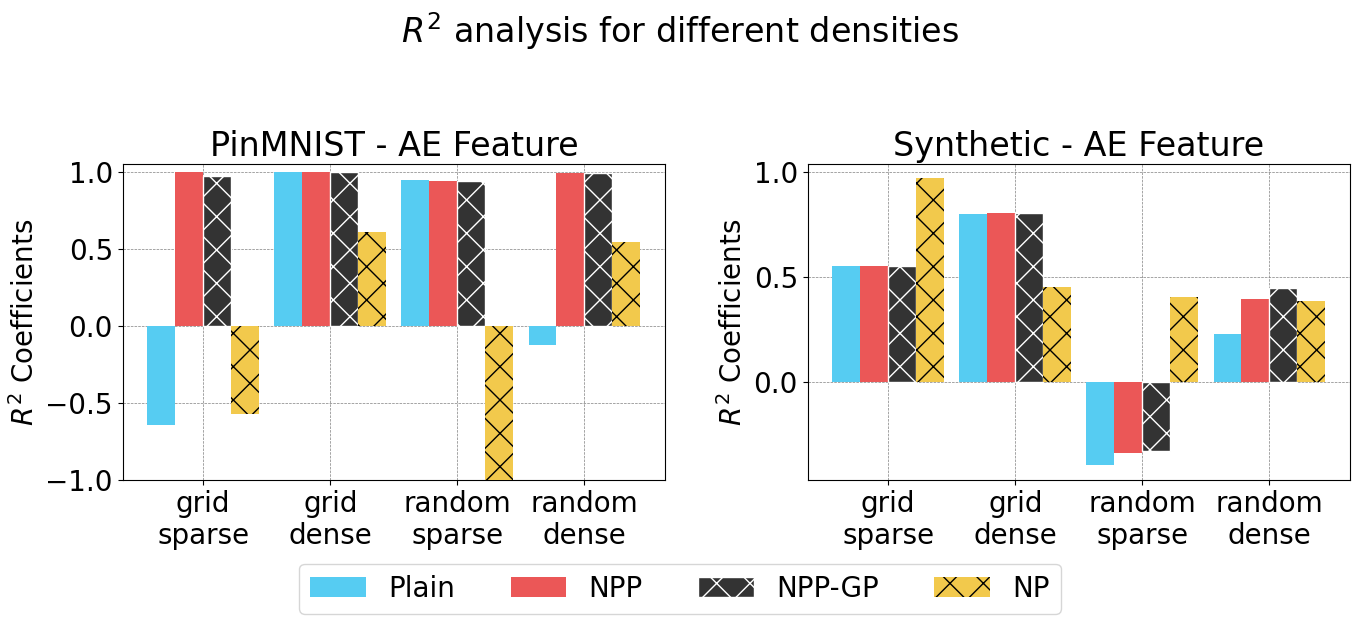

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)
#plt.rcParams['text.usetex'] = True

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature AE
feature_data = df[df['Feature'] == 'AE']

# Separate data by dataset
datasets = feature_data['Dataset'].unique()
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "."]
labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[-0.576, 0.607, -200.553, 0.546], [0.969, 0.452, 0.405, 0.388]]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(14, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
    mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    ax.set_title(f'{dataset} - AE Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 0:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("AE_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


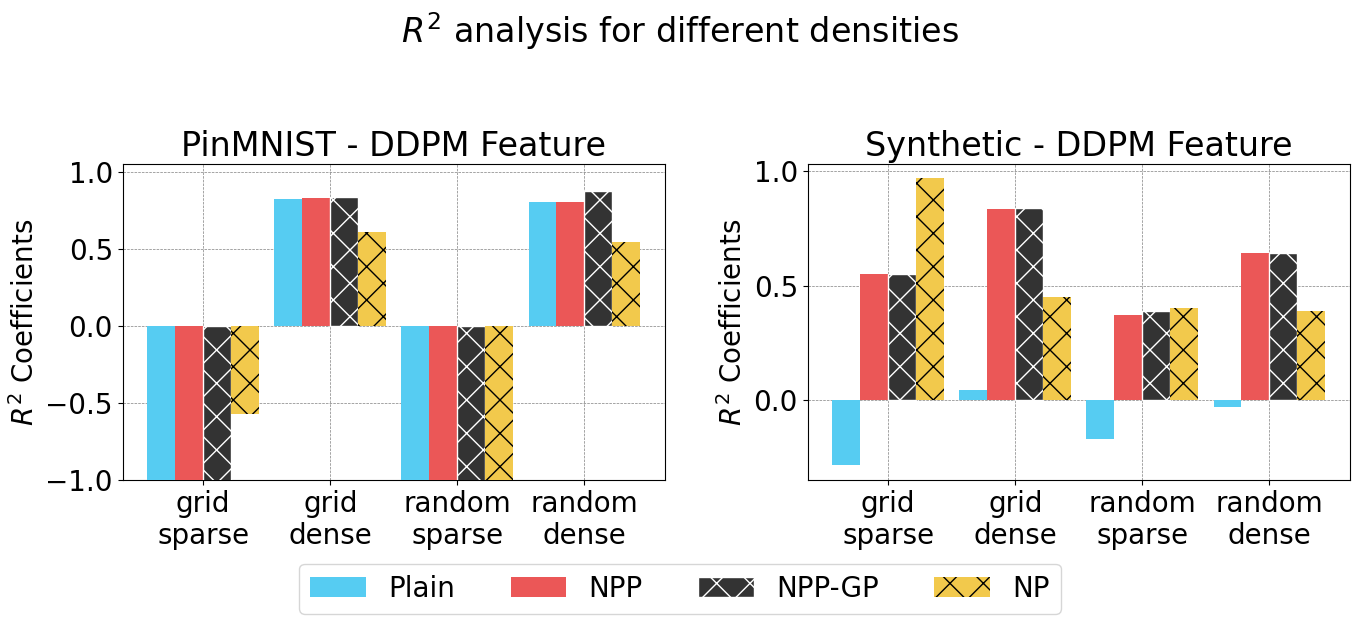

In [16]:
import matplotlib.pyplot as plt
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature DDPM
feature_data = df[df['Feature'] == 'DDPM']

# Separate data by dataset
datasets = feature_data['Dataset'].unique()
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "x"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[-0.576, 0.607, -200.553, 0.546], [0.969, 0.452, 0.405, 0.388]]

labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(14, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
    mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    ax.set_title(f'{dataset} - DDPM Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 0:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("DDPM_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


In [30]:
# NP Results
x_NP = [0.25, 0.50, 0.75, 1.00]
Synthetic = {
 "grid sparse": [0.969, 0.971, 0.972, 0.969], # Grid Sparse
 "grid dense": [0.408, 0.440, 0.448, 0.452], # Grid Dense
 "random sparse": [0.418, 0.412, 0.416, 0.405], # Random Sparse
 "random dense": [0.306, 0.357, 0.385, 0.388]} # Random Dense
PinMNIST = {
 "grid sparse": [-0.576, -0.577, -0.576, -0.576], # Grid Sparse
 "grid dense": [0.535, 0.580, 0.600, 0.607], # Grid Dense
 "random sparse": [-125.973, -131.527, -252.488, -200.553], # Random Sparse
 "random dense": [0.459, 0.518, 0.534, 0.546]} # Random Dense
Buildings = {
 "grid sparse": [], # Grid Sparse
 "grid dense": [], # Grid Dense
 "random sparse": [], # Random Sparse
 "random dense": []} # Random Dense
NP = [PinMNIST, Synthetic, Buildings]

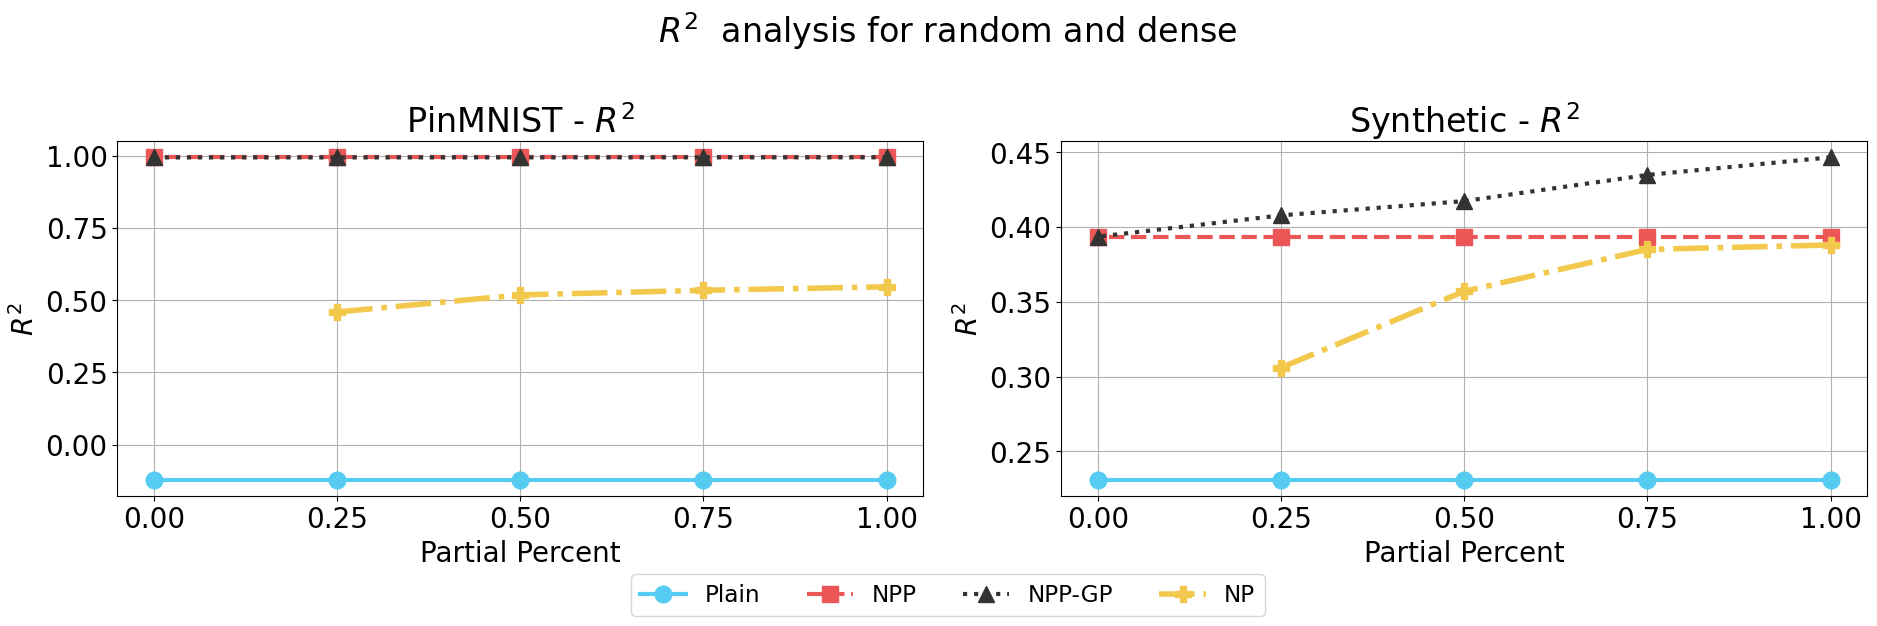

In [37]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'AE') & (df['Extra layers'] == False)]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP', 'GP']
data_names = ['Plain', 'NPP', 'NPP-GP']
datasets = df_ae['Dataset'].unique()
modes = ['random'] #df_ae['Mode'].unique()
npins = [100] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(19, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric):
    for mode_idx, mode in enumerate(modes):
        for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
            for data_group_idx, data_group in enumerate(data_groups):
                # Filter the dataset for the specific conditions
                df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
                if df_filtered.empty:
                    continue
                label = data_names[data_group_idx]
                color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                marker =  markers[data_group_idx] #markers[data_group_idx]
                ax.plot(df_filtered['Partial Percent'], df_filtered[data_group] if metric == 'MSE' else df_filtered[f'R2 {data_group}'],
                        label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
    ax.plot(x_NP, NP[j][f"{modes[0]} {density}"],
                        label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=4)
# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if i == 0:
    #    axs[i, j].set_yscale('log')
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
fig.suptitle(f'$R^2$  analysis for {mode_name} and {density}')
plt.tight_layout()
plt.savefig(f"AE_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

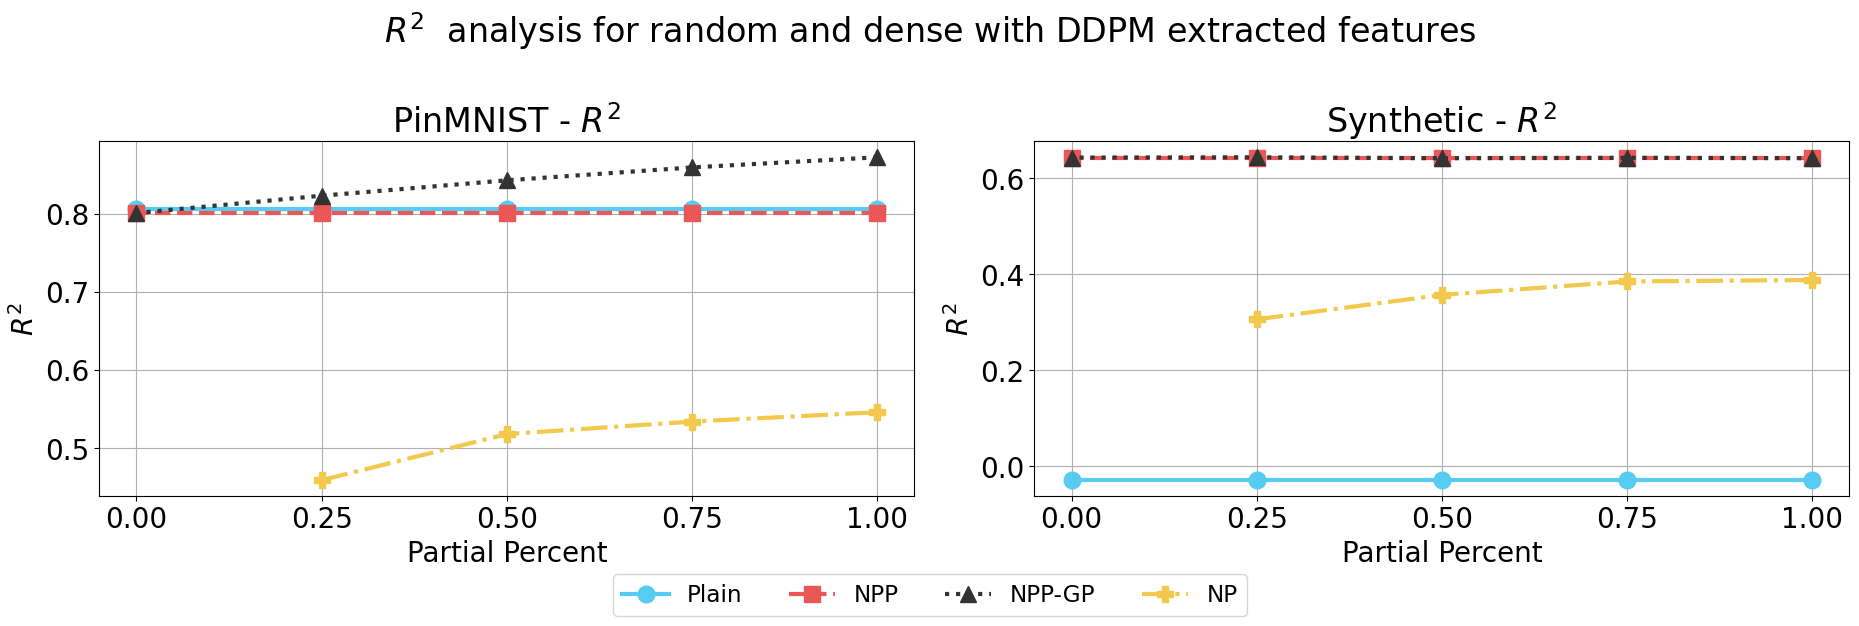

In [36]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'DDPM') & (df['Extra layers'] == False)]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP', 'GP']
data_names = ['Plain', 'NPP', 'NPP-GP']
datasets = df_ae['Dataset'].unique()
modes = ['random'] #df_ae['Mode'].unique()
npins = [100] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(19, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric):
    for mode_idx, mode in enumerate(modes):
        for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
            for data_group_idx, data_group in enumerate(data_groups):
                # Filter the dataset for the specific conditions
                df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
                if df_filtered.empty:
                    continue
                label = data_names[data_group_idx]
                color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                marker =  markers[data_group_idx] #markers[data_group_idx]
                ax.plot(df_filtered['Partial Percent'], df_filtered[data_group] if metric == 'MSE' else df_filtered[f'R2 {data_group}'],
                        label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
    ax.plot(x_NP, NP[j][f"{modes[0]} {density}"],
                        label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=3)
# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if i == 0:
    #    axs[i, j].set_yscale('log')
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
fig.suptitle(f'$R^2$  analysis for {mode_name} and {density} with DDPM extracted features')
plt.tight_layout()
plt.savefig(f"DDPM_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

In [4]:
df[(df['Dataset'] == 'PinMNIST') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True).to_csv('pinMNIST.csv', index=False)
df[(df['Dataset'] == 'PinMNIST') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True)

,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,PinMNIST,AE,mesh,100,1.00,0.180671,0.996895,0.2,0.166074,0.997135,0.165522,0.997145
1,PinMNIST,AE,mesh,100,0.75,0.180671,0.996895,0.2,0.166074,0.997135,0.165615,0.997143
2,PinMNIST,AE,mesh,100,0.50,0.180671,0.996895,0.2,0.166074,0.997135,0.165733,0.997141
3,PinMNIST,AE,mesh,100,0.25,0.180671,0.996895,0.2,0.166074,0.997135,0.165913,0.997138
4,PinMNIST,AE,mesh,100,0.00,0.180671,0.996895,0.2,0.166074,0.997135,0.166074,0.997135
5,PinMNIST,AE,mesh,9,1.00,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.971716
6,PinMNIST,AE,mesh,9,0.75,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.971716
7,PinMNIST,AE,mesh,9,0.50,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.976180
8,PinMNIST,AE,mesh,9,0.25,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.976180
9,PinMNIST,AE,mesh,9,0.00,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.994037


In [5]:
df[(df['Dataset'] == 'Synthetic') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True).to_csv('Synthetic.csv', index=False)
df[(df['Dataset'] == 'Synthetic') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True)

,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,Synthetic,AE,mesh,100,1.00,13.901962,0.782908,0.5,14.245438,0.777145,14.081051,0.779755
1,Synthetic,AE,mesh,100,0.75,13.901962,0.782908,0.5,14.245438,0.777145,14.123055,0.779089
2,Synthetic,AE,mesh,100,0.50,13.901962,0.782908,0.5,14.245438,0.777145,14.157693,0.778540
3,Synthetic,AE,mesh,100,0.25,13.901962,0.782908,0.5,14.245438,0.777145,14.206275,0.777771
4,Synthetic,AE,mesh,100,0.00,13.901962,0.782908,0.5,14.245438,0.777145,14.245438,0.777145
5,Synthetic,AE,mesh,9,1.00,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
6,Synthetic,AE,mesh,9,0.75,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
7,Synthetic,AE,mesh,9,0.50,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
8,Synthetic,AE,mesh,9,0.25,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
9,Synthetic,AE,mesh,9,0.00,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756


TESTING

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tools.plot_utils import plot_and_save
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, evaluate_model
import matplotlib.pyplot as plt
import argparse
import time
from tools.models import *

experiment_id = "1709622898" # 1709521764
experiment_folder = "./history/exp_def"
dataset = "Synthetic"
feature = "DDPM"
mode = "random"
feature_extracted = True if feature == "DDPM" else False
mesh = True if mode == "mesh" else False
d = 3
n_pins = 100
partial_percent = 0.25
r = 3
batch_size = 32

num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]


# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

if dataset == "Synthetic":
    input_channel = 3 
elif dataset == "PinMNIST":
    input_channel = 1
elif dataset == "Building":
    input_channel = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
        config['n_pins'] = (28//d + 1)**2
    else:
        data_folder = f"./data/{folder}/random_fixedTrue_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"
elif dataset == "Synthetic":
    folder += "/28by28pixels_1000images_123456seed"
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_pins"
        config['n_pins'] = (28//d + 1)**2
    else:
        data_folder = f"./data/{folder}/random_{n_pins}pins"
else: # dataset == "Building"
    raise Exception("Building option is still not implemented.")

transform = transforms.Compose([
    ToTensor(),         # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"./data/{folder}/images/",
                                      transform=transform)

dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)        

In [ ]:
# Testing
dataloader = train_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
experiment_id = 1709000615
dataloader = test_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth'))
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth'))
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")
    # NPP
    for percent in [0.25, 0.50, 0.75, 1.00]:
        print(f'Percent testing {percent}')
        best_MSE_test_loss = evaluate_model(autoencoder_MSE, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        try:
            GP_best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=True, partial_percent=percent)
            # Write output into file
            filename = f"test_{folder.split('/')[0]}_{percent}.txt"
            with open(f"{experiment_folder}/{experiment_id}/{filename}", "w") as f:
                f.write(f"MSE {best_MSE_test_loss}; NPP {best_NPP_test_loss}, {GP_best_NPP_test_loss} (GP)")
        except Exception as Error:
            print(Error)